In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift

In [304]:
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Blinking.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_recorder/EyeBlinking(new2).csv", sep=",")
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/EEGdata-2024-149--15-45-38.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_labels/Label_2024-144--15-54-35_2.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_Test/Label0Test.csv", sep=",")
end = df.shape[0]-5
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,243596.296875,251218.687500,259010.062500,251347.250000,221692.921875,242380.453125,239539.000000,225249.625000
1,243679.984375,251313.109375,259103.484375,251418.781250,221832.046875,242420.234375,239745.187500,225272.328125
2,243742.750000,251406.265625,259215.515625,251469.031250,222011.484375,242448.312500,240012.781250,225285.125000
3,243683.734375,251364.875000,259189.328125,251425.484375,221980.906250,242423.812500,239972.546875,225270.015625
4,243600.953125,251254.000000,259068.718750,251354.406250,221788.140625,242383.937500,239689.125000,225251.140625
...,...,...,...,...,...,...,...,...
71995,242800.578125,250025.375000,252553.171875,245610.187500,220302.468750,241147.625000,237832.046875,224287.781250
71996,242839.109375,250098.515625,252637.125000,245663.125000,220465.015625,241181.953125,238073.000000,224297.625000
71997,242836.781250,250131.406250,252692.390625,245675.187500,220579.000000,241191.609375,238241.437500,224298.515625
71998,242782.687500,250063.015625,252631.593750,245621.359375,220477.968750,241159.062500,238089.812500,224286.984375


In [305]:
# Define the segment size
prompt_size = 1500
prompts = end/prompt_size

for i in range(int(prompts)):
    df.iloc[1500*i : 1500*(i+1)] = signal.detrend(df.iloc[1500*i : 1500*(i+1)], axis = 0)

df_filt_detr = np.array(df)

In [306]:
from scipy.signal import butter, lfilter, filtfilt
from scipy import signal

# Define the filter parameters
lowcut = 2
highcut = 30
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(4, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
df_filt = lfilter(b, a, df_filt_detr, axis = 0)

# import scipy.signal as signal

# Define the notch filter parameters
fs = 250  # Sampling frequency
f0 = 50  # Notch frequency
Q = 1 # Quality factor

# Design the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt, axis = 0)

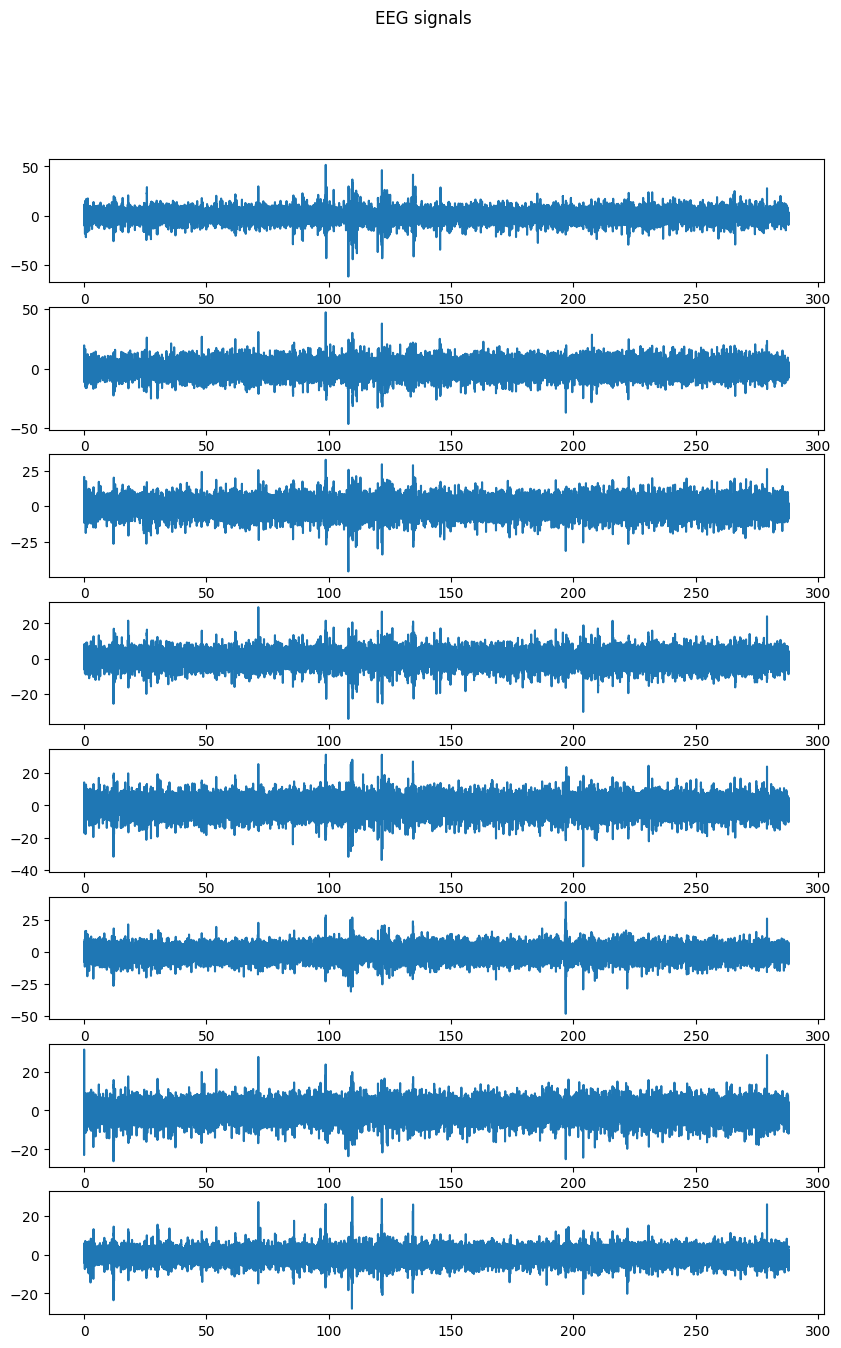

In [307]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1[:],df_filt1[:,i])

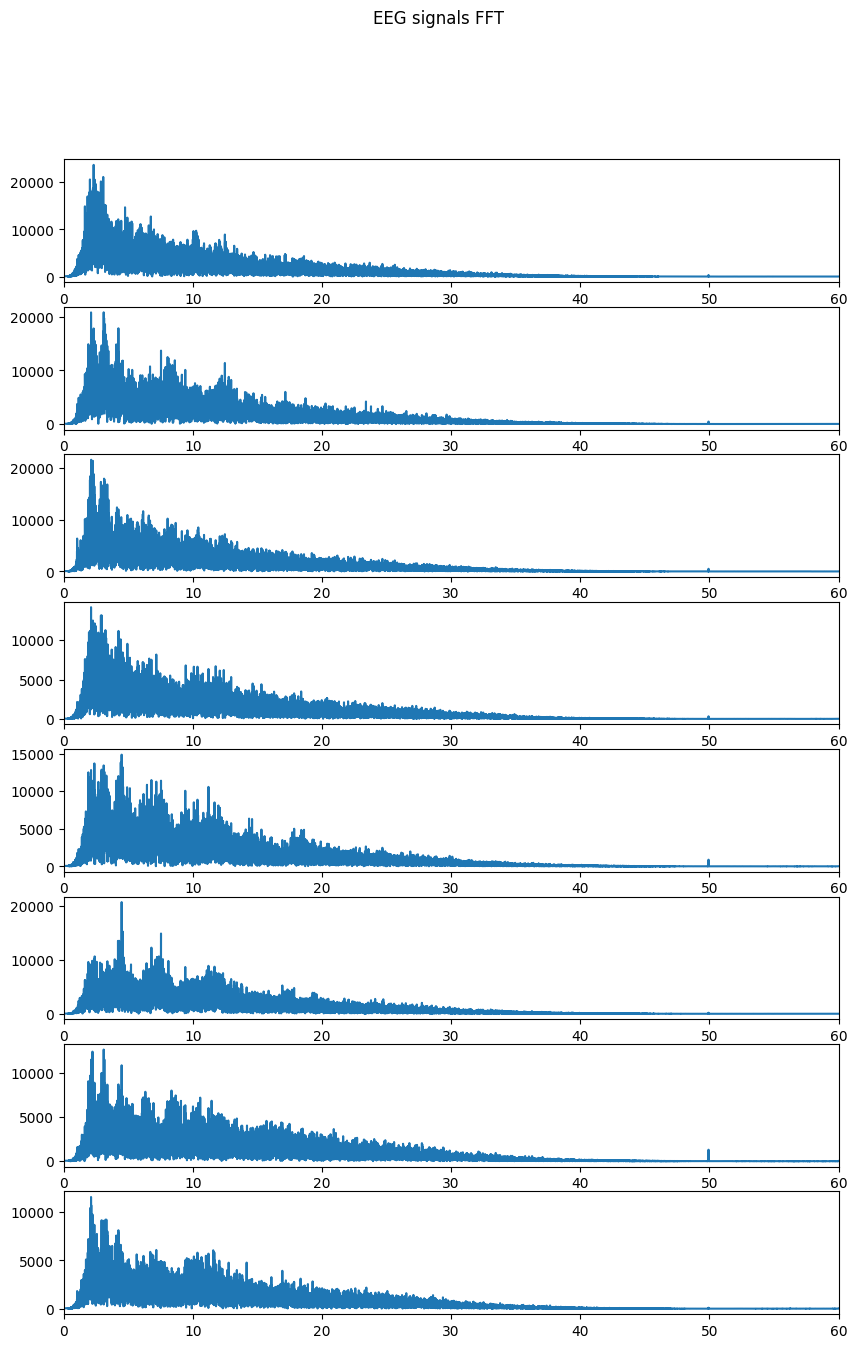

In [308]:
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf[:], np.abs(yf))
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    

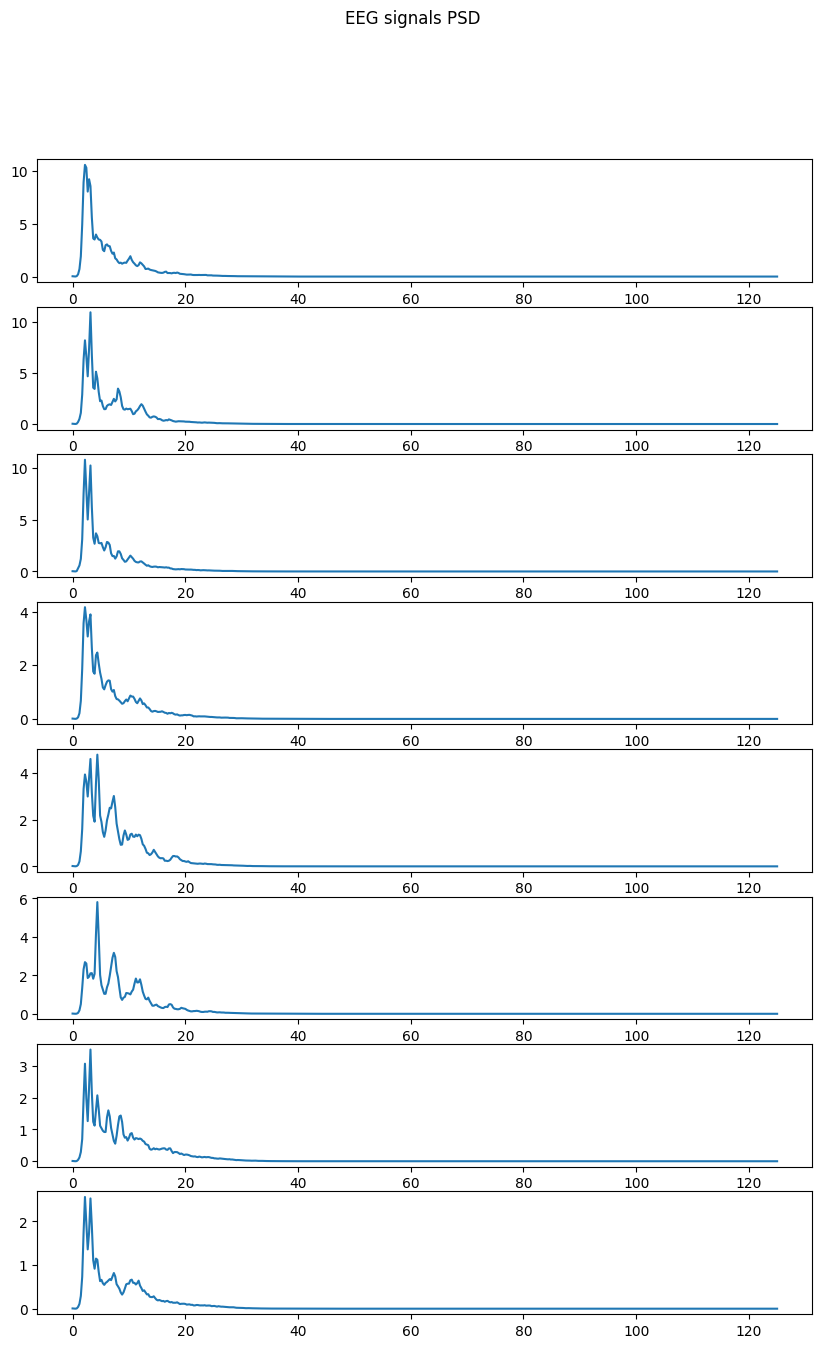

In [309]:
from scipy import signal

xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals PSD')
for i in range(8):
    # Compute the power spectral density
    frequencies, power_density = signal.welch(df_filt1[:,i], fs, nperseg=1024, scaling='density')


    # Plot the power spectral density
    axs[i].plot(frequencies, power_density)
    #plt.psd(df[:,i], Fs = 250)
    #axs[i].xlabel('Frequency (Hz)')
    #axs[i].ylabel('Power Spectral Density')
    #axs[i].title('Power Spectral Density Plot')




In [310]:
import mne
from mne.preprocessing import ICA
# Constants
num_components = 8
allOutputs = df_filt1

channels = allOutputs.T

# create mne_info object
ch_names =        ['Fz', 
            'C3',  'Cz',  'C4', 
                   'Pz', 
            'PO7', 'Oz',  'PO8']

ch_type = ['eeg' for i in range(8)]
mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

#create mne.raw object
raw = mne.io.RawArray(channels, mne_info)
raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

Creating RawArray with float64 data, n_channels=8, n_times=72000


    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 413 samples (1.652 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.2s.
Creating RawArray with float64 data, n_channels=8, n_times=72000
    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


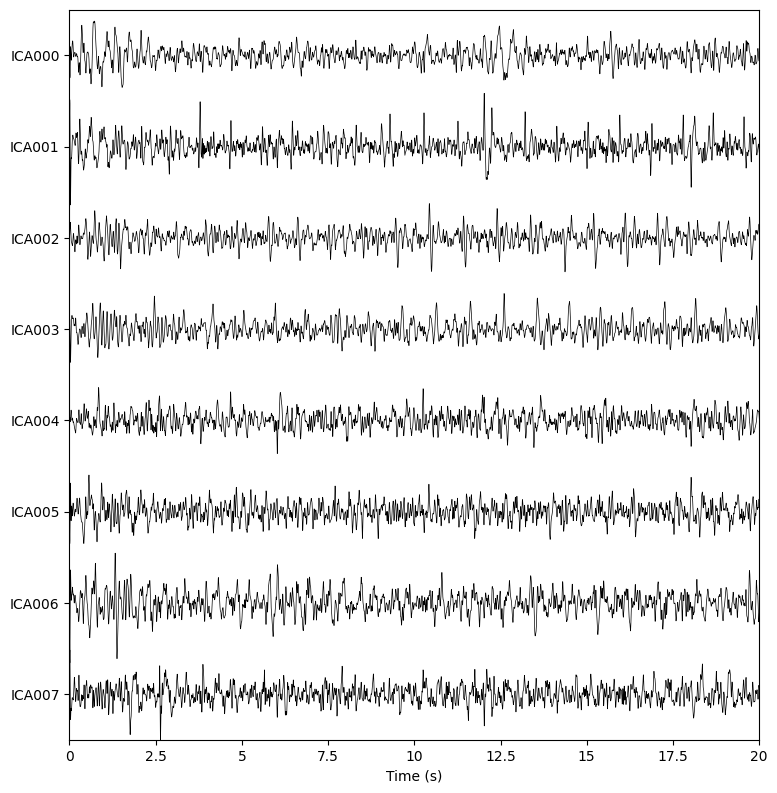

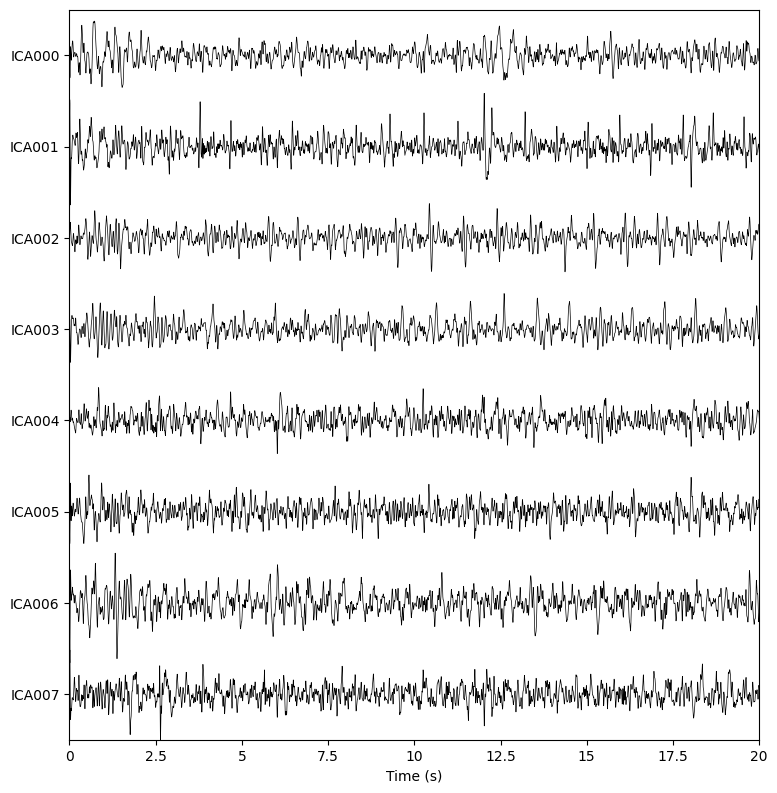

In [311]:
filt_raw = raw.copy().filter(l_freq=2.0, h_freq=None)
ica = ICA(n_components=8, max_iter="auto", random_state=97)
ica.fit(filt_raw)
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

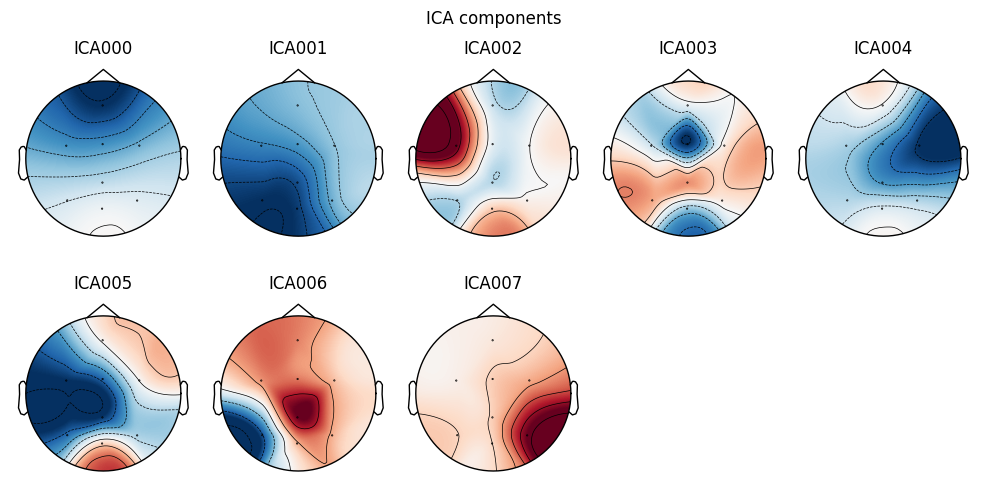

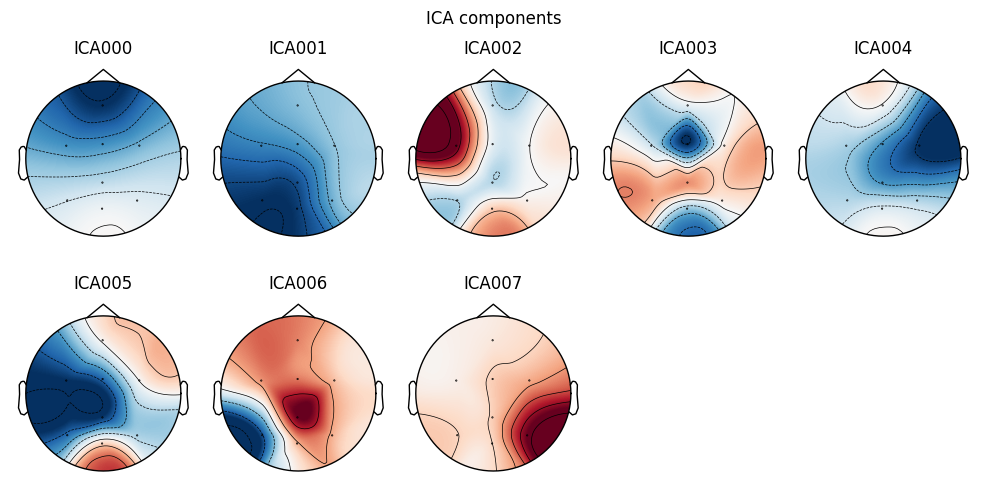

In [312]:
ica.plot_components(picks=range(num_components), ch_type='eeg')

In [313]:
from mne_icalabel import label_components
# assuming you have a Raw and ICA instance previously fitted
labels = label_components(raw, ica, method='iclabel')

y_pred_proba = labels['y_pred_proba']

print(y_pred_proba)
# Filter values greater than 0.7 using NumPy
exclude = np.where(y_pred_proba < 0.90)[0]
print(exclude)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\JackC\AppData\Local\Temp\ipykernel_14996\3627005593.py:3: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')
C:\Users\JackC\AppData\Local\Temp\ipykernel_14996\3627005593.py:3: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')
C:\Users\JackC\AppData\Local\Temp\ipykernel_14996\3627005593.py:3: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended inf

[0.52567494 0.6117153  0.9481347  0.9261622  0.98052263 0.9861137
 0.9836421  0.9611833 ]
[0 1]


Applying ICA to Raw instance


    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


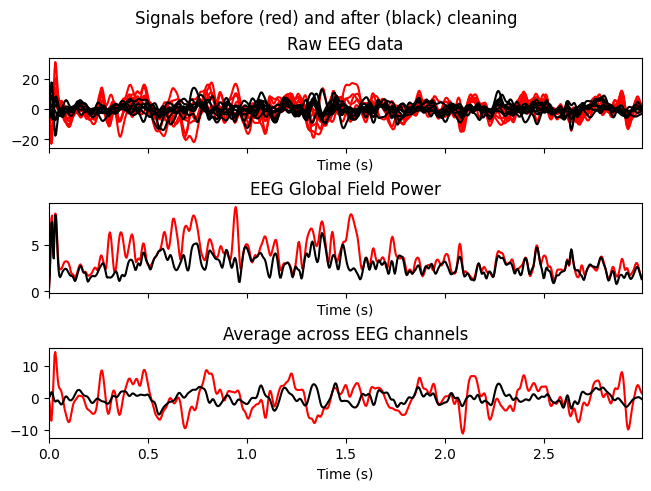

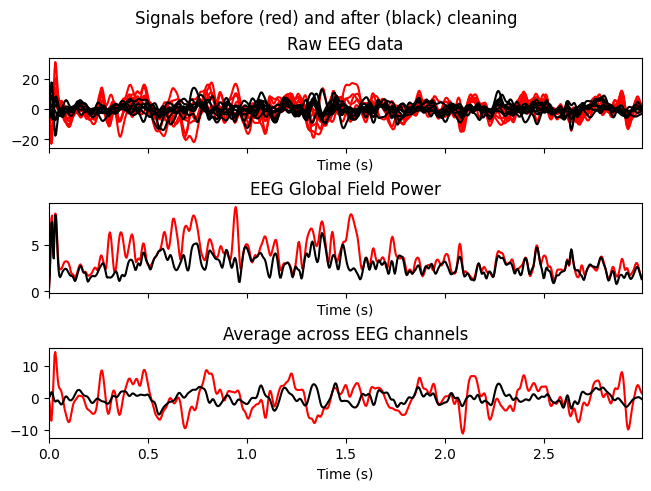

In [314]:
# blinks
ica.plot_overlay(raw, exclude=exclude, picks="eeg")

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated


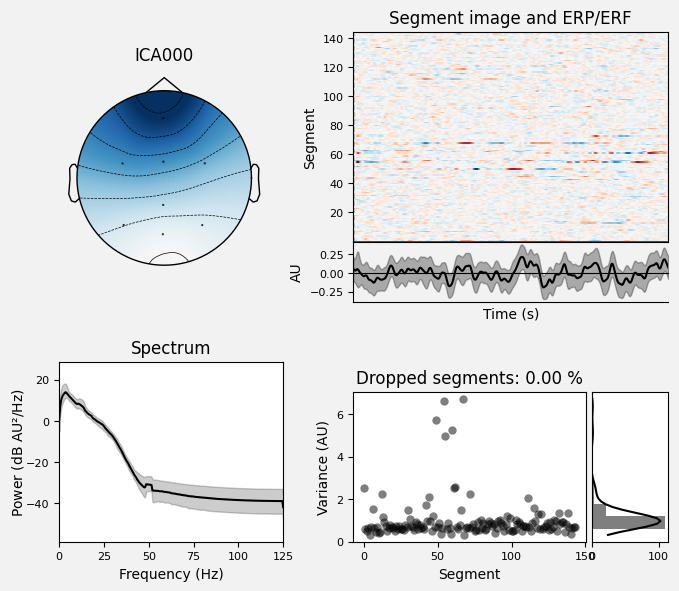

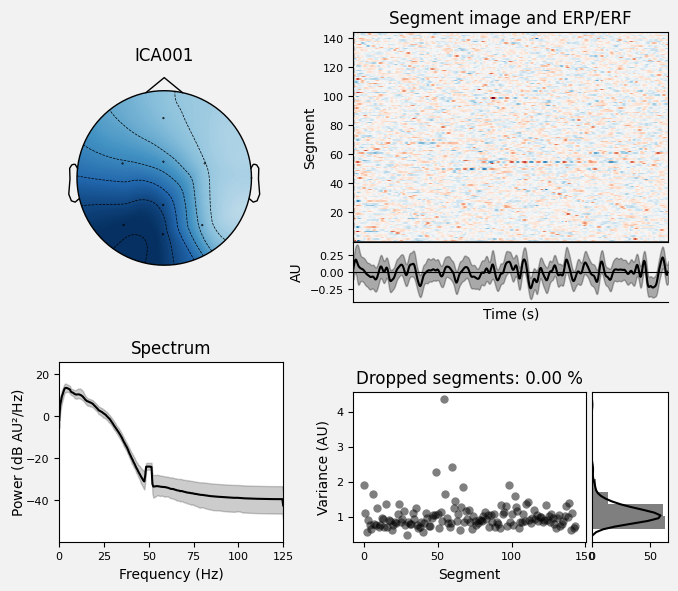

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [315]:
ica.plot_properties(raw, picks=[0,1])

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


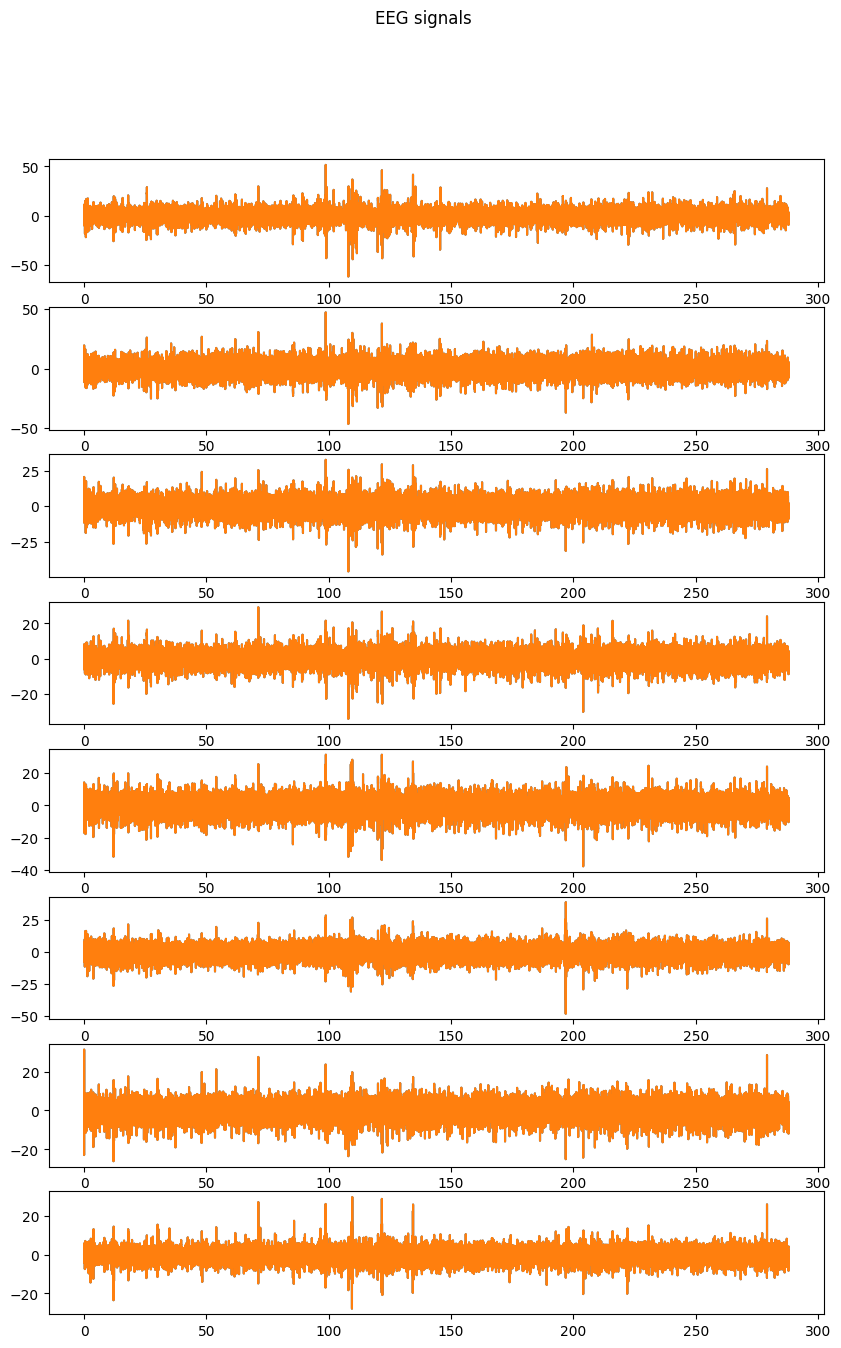

In [318]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

reconst_signal = raw[:][0].T
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1[:],reconst_signal[:,i])
    axs[i].plot(x1[:],df_filt1[:,i])